In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset (use relative paths for portability)
X_train = pd.read_csv('dataset/features-train.tsv', sep='\t')
X_test = pd.read_csv('dataset/features-test.tsv', sep='\t')
y_train = pd.read_csv('dataset/labels-train.tsv', sep='\t')


if 'is_human' in y_train.columns:
    y_train['target'] = (
        y_train['is_human']
        .replace({'true': True, 'false': False})
        .astype(int) if y_train['is_human'].dtype == object else y_train['is_human'].astype(int)
    )


In [37]:
X_test.columns

Index(['id', 'num_characters', 'num_sentences', 'num_words',
       'num_unique_words', 'num_stop_words', 'stop_word_ratio',
       'avg_word_length', 'avg_sentence_length', 'num_punctuation',
       'punctuation_sentence_ratio', 'num_digits', 'digit_ratio',
       'type_token_ratio', 'num_uppercase', 'uppercase_ratio',
       'flesch_reading_ease', 'entropy', 'has_question_mark',
       'has_exclamation_mark', 'num_adjectives', 'adjective_ratio',
       'num_repeated_words', 'repeated_word_ratio'],
      dtype='object')

In [15]:
y_train.head()

,id,is_human,target
0,0,True,1
1,1,True,1
2,2,True,1
3,3,True,1
4,4,False,0


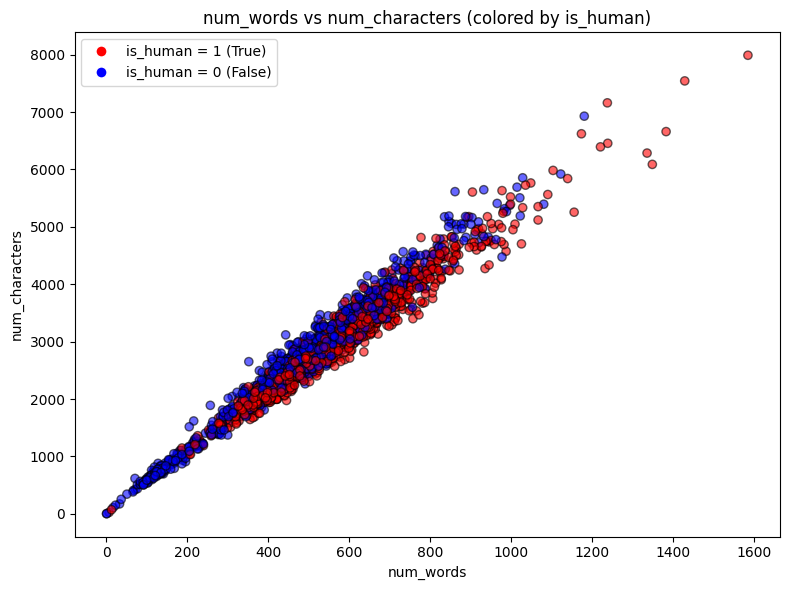

In [18]:
# Scatter plot entre dos features coloreado por is_human

# Seleccionar features
f1 = 'num_words'
f2 = 'num_characters'

assert f1 in X_train.columns and f2 in X_train.columns, "Faltan columnas en X_train."

colors = ['red' if v == 1 else 'blue' for v in y_train['target']]

plt.figure(figsize=(8, 6))
plt.scatter(X_train[f1], X_train[f2], c=colors, alpha=0.6, edgecolor='k')
plt.xlabel(f1)
plt.ylabel(f2)
plt.title(f'{f1} vs {f2} (colored by is_human)')

from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0],[0], marker='o', color='w', label='is_human = 1 (True)', markerfacecolor='red', markersize=8),
    Line2D([0],[0], marker='o', color='w', label='is_human = 0 (False)', markerfacecolor='blue', markersize=8)
]
plt.legend(handles=legend_elements, loc='best')
plt.tight_layout()
plt.show()

LMS weights (standardized): [ 0.51114112  0.96429517 -0.8938317 ]
LMS weights (original space): W0= 0.3741736629810082  W1= 0.0049868144987746475  W2= -0.0008699564107775654


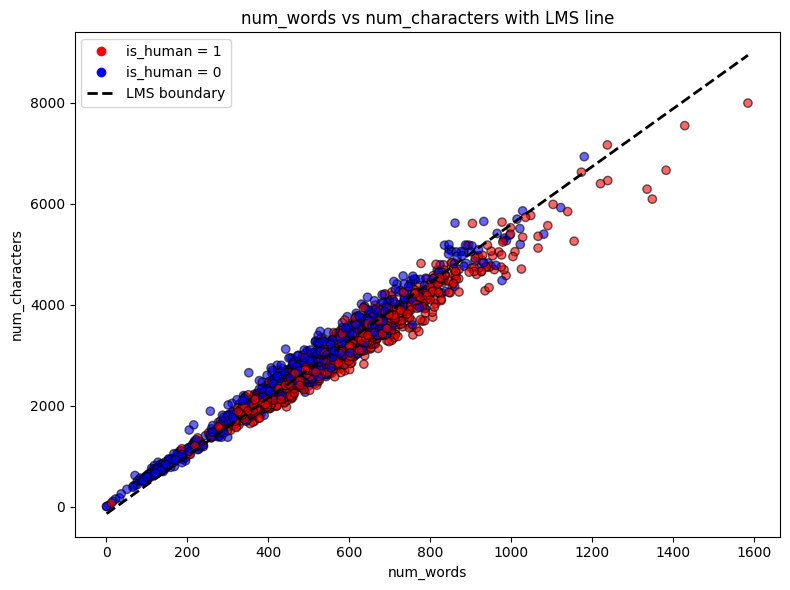

In [19]:
# LMS (Least Mean Squares) for two features and decision line on the scatter plot

# Ensure target exists (0/1)
if 'target' not in y_train.columns and 'is_human' in y_train.columns:
    y_train['target'] = (y_train['is_human'].replace({'true': True, 'false': False})
                         .astype(int) if y_train['is_human'].dtype == object else y_train['is_human'].astype(int))

# Select two features
f1, f2 = 'num_words', 'num_characters'
assert f1 in X_train.columns and f2 in X_train.columns, "Missing columns."

# Prepare data
X2 = X_train[[f1, f2]].astype(float).copy()
y = y_train['target'].astype(float).values

# Standardize features (better convergence)
mu = X2.mean()
sigma = X2.std().replace(0, 1.0)
X_std = (X2 - mu) / sigma
X_vals = X_std.values

# LMS training (SGD)
np.random.seed(0)
w = np.zeros(3)  # [w0, w1, w2]
lr = 0.01
epochs = 50

for _ in range(epochs):
    idx = np.random.permutation(len(X_vals))
    for i in idx:
        x1, x2 = X_vals[i]
        x_aug = np.array([1.0, x1, x2])
        y_hat = np.dot(w, x_aug)
        e = y[i] - y_hat
        w += lr * e * x_aug

# Convert weights to original feature space for plotting the line
W0 = w[0] - w[1]*mu[f1]/sigma[f1] - w[2]*mu[f2]/sigma[f2]
W1 = w[1] / sigma[f1]
W2 = w[2] / sigma[f2]

print("LMS weights (standardized):", w)
print("LMS weights (original space): W0=", W0, " W1=", W1, " W2=", W2)

# Scatter plot with decision line y_hat = 0.5  =>  W0 + W1*x + W2*y = 0.5
colors = ['red' if v == 1 else 'blue' for v in y_train['target']]
plt.figure(figsize=(8, 6))
plt.scatter(X_train[f1], X_train[f2], c=colors, alpha=0.6, edgecolor='k', label='Train samples')

# Plot decision line if W2 != 0
if abs(W2) > 1e-12:
    x_min, x_max = X_train[f1].min(), X_train[f1].max()
    x_grid = np.linspace(x_min, x_max, 200)
    y_line = (0.5 - W0 - W1 * x_grid) / W2
    plt.plot(x_grid, y_line, 'k--', linewidth=2, label='LMS boundary (ŷ=0.5)')

plt.xlabel(f1)
plt.ylabel(f2)
plt.title(f'{f1} vs {f2} with LMS line')
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0],[0], marker='o', color='w', label='is_human = 1', markerfacecolor='red', markersize=8),
    Line2D([0],[0], marker='o', color='w', label='is_human = 0', markerfacecolor='blue', markersize=8)
]
plt.legend(handles=legend_elements + [Line2D([0],[0], color='k', lw=2, linestyle='--', label='LMS boundary')], loc='best')
plt.tight_layout()
plt.show()

In [ ]:

# Select two features
f1, f2 = 'num_words', 'num_characters'
assert f1 in X_train.columns and f2 in X_train.columns, "Missing columns."

# Prepare data
X2 = X_train[[f1, f2]].astype(float).copy()
y = y_train['target'].astype(float).values
# Standardize features (better convergence)
mu = X2.mean()
sigma = X2.std().replace(0, 1.0)
X_std = (X2 - mu) / sigma
X_vals = X_std.values

LMS weights (standardized): [ 0.51114112  0.96429517 -0.8938317 ]
LMS weights (original space): W0= 0.3741736629810082  W1= 0.0049868144987746475  W2= -0.0008699564107775654


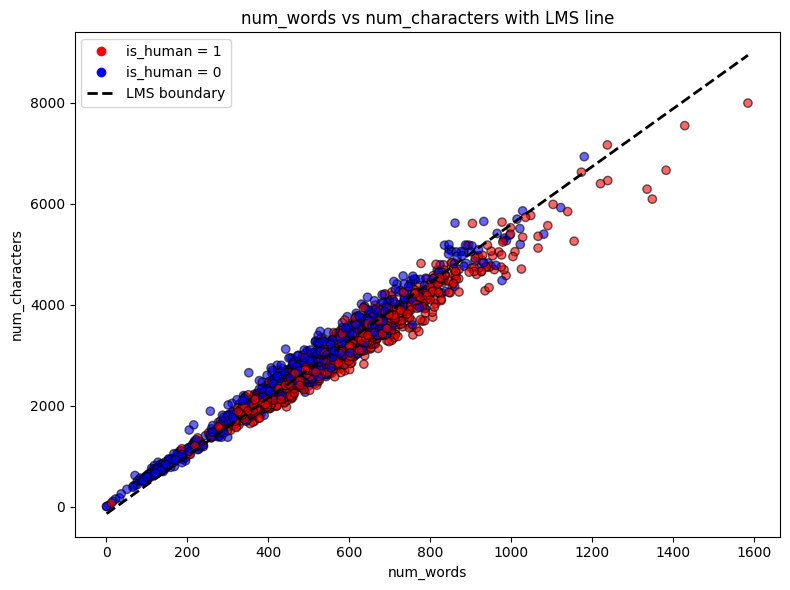

In [ ]:
# LMS training (SGD)
np.random.seed(0)
w = np.zeros(3)  # [w0, w1, w2]
lr = 0.01
epochs = 50

for j in range(epochs):
    idx = np.random.permutation(len(X_vals))
    for i in idx:
        x1, x2 = X_vals[i]
        Xvalues = np.array([1, x1, x2])
        ypre = np.dot(w, Xvalues)
        error = y[i]-ypre
        w = w + lr*error*Xvalues

# Convert weights to original feature space for plotting the line
W0 = w[0] - w[1]*mu[f1]/sigma[f1] - w[2]*mu[f2]/sigma[f2]
W1 = w[1] / sigma[f1]
W2 = w[2] / sigma[f2]

print("LMS weights (standardized):", w)
print("LMS weights (original space): W0=", W0, " W1=", W1, " W2=", W2)

# Scatter plot with decision line y_hat = 0.5  =>  W0 + W1*x + W2*y = 0.5
colors = ['red' if v == 1 else 'blue' for v in y_train['target']]
plt.figure(figsize=(8, 6))
plt.scatter(X_train[f1], X_train[f2], c=colors, alpha=0.6, edgecolor='k', label='Train samples')

# Plot decision line if W2 != 0
if abs(W2) > 1e-12:
    x_min, x_max = X_train[f1].min(), X_train[f1].max()
    x_grid = np.linspace(x_min, x_max, 200)
    y_line = (0.5 - W0 - W1 * x_grid) / W2
    plt.plot(x_grid, y_line, 'k--', linewidth=2, label='LMS boundary (ŷ=0.5)')

plt.xlabel(f1)
plt.ylabel(f2)
plt.title(f'{f1} vs {f2} with LMS line')
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0],[0], marker='o', color='w', label='is_human = 1', markerfacecolor='red', markersize=8),
    Line2D([0],[0], marker='o', color='w', label='is_human = 0', markerfacecolor='blue', markersize=8)
]
plt.legend(handles=legend_elements + [Line2D([0],[0], color='k', lw=2, linestyle='--', label='LMS boundary')], loc='best')
plt.tight_layout()
plt.show()

In [ ]:
 # Task a) Select two features (e.g. num_words and num_characters) and plot a scatterplot for the examples in
    # the training set between the two features. Color the points according to the class is_human. Submit
    # the plot.

    # Task b) Implement the LMS algorithm and use it to compute the weight vector (w0, w1, w2) and add the line
    # of best fit to your plot from (a). Submit your algorithm implementation and the updated plot.

    print("LMS weights (standardized):", w)
    print("LMS weights (original space): W0=", W0, " W1=", W1, " W2=", W2)

    # Scatter plot with decision line y_hat = 0.5  =>  W0 + W1*x + W2*y = 0.5
    colors = ['red' if v == 1 else 'blue' for v in y_train['target']]
    plt.figure(figsize=(8, 6))
    plt.scatter(X_train[f1], X_train[f2], c=colors, alpha=0.6, edgecolor='k', label='Train samples')

    # Plot decision line if W2 != 0
    if abs(W2) > 1e-12:
        x_min, x_max = X_train[f1].min(), X_train[f1].max()
        x_grid = np.linspace(x_min, x_max, 200)
        y_line = (0.5 - W0 - W1 * x_grid) / W2
        plt.plot(x_grid, y_line, 'k--', linewidth=2, label='LMS boundary (ŷ=0.5)')

    plt.xlabel(f1)
    plt.ylabel(f2)
    plt.title(f'{f1} vs {f2} with LMS line')
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0],[0], marker='o', color='w', label='is_human = 1', markerfacecolor='red', markersize=8),
        Line2D([0],[0], marker='o', color='w', label='is_human = 0', markerfacecolor='blue', markersize=8)
    ]
    plt.legend(handles=legend_elements + [Line2D([0],[0], color='k', lw=2, linestyle='--', label='LMS boundary')], loc='best')
    plt.tight_layout()
    plt.show()



    colors = ['red' if v == 1 else 'blue' for v in y_train['target']]

    plt.figure(figsize=(8, 6))
    plt.scatter(X_train[f1], X_train[f2], c=colors, alpha=0.6, edgecolor='k')
    plt.xlabel(f1)
    plt.ylabel(f2)
    plt.title(f'{f1} vs {f2} (colored by is_human)')

    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0],[0], marker='o', color='w', label='is_human = 1 (True)', markerfacecolor='red', markersize=8),
        Line2D([0],[0], marker='o', color='w', label='is_human = 0 (False)', markerfacecolor='blue', markersize=8)
    ]
    plt.legend(handles=legend_elements, loc='best')
    plt.tight_layout()
    plt.show()


In [1]:
0.5/1

0.5